## Test of the Graph Hierarchies

In [8]:
%matplotlib inline

import os.path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
from scipy.spatial.transform import Rotation

from pygsp import graphs, filters, plotting, reduction
from fgsp.graph.wavelet_evaluator import WaveletEvaluator
from fgsp.graph.global_graph import GlobalGraph

%load_ext autoreload
%autoreload 2

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def create_signal_from_traj(traj):
    traj_origin = traj[0,:]
    pos_signal = (traj - traj_origin).squeeze()
    x_pos = np.linalg.norm(pos_signal, ord=2, axis=1)
    return x_pos

## 1. Test of Simple Displacement

[1660836559117092.2] GlobalGraph: Initialized.
[1660836559117438.5] Unknown construction method or not enough dimensions. Using position only. 
[1660836559234625.2] GlobalGraph: Initialized.
[1660836559234953.5] Unknown construction method or not enough dimensions. Using position only. 


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=7, n_edges=13)'}>)

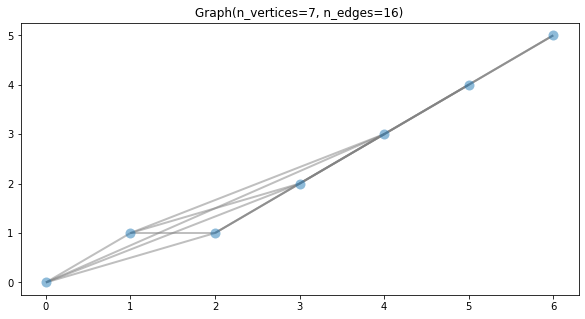

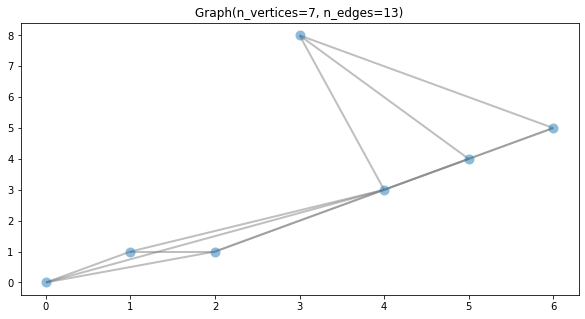

In [17]:
opt_traj = np.array([[0,0,0,0],[1,1,0,1],[2,1,2,1],[3,2,2,1],[4,3,3,1],[5,4,4,1],[6,5,6,2]])
opt_graph = GlobalGraph(None)
opt_graph.build_from_poses(opt_traj)
opt_graph.G.plot()

est_traj = np.array([[0,0,0,0],[1,1,0,1],[2,1,2,1],[3,8,2,1],[4,3,3,1],[5,4,4,1],[6,5,6,2]])
est_graph = GlobalGraph(None)
est_graph.build_from_poses(est_traj)
est_graph.G.plot()
